In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/6"))
dh_low = DataHandler.from_specs(
    "ERA5", "plev", "mid_wind", "6H", "all", None, -80, 40, 15, 80, "all"
)
ds = exp.ds
all_jets_one_df = exp.find_jets()
all_jets_one_df = exp.categorize_jets(dh_low.da["s"])
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
props_as_df.write_parquet(exp.path.joinpath("props_as_df_extras.parquet"))

# Trends

In [17]:
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
    "double_jet_index",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(
        props_as_df,
        data_vars,
        season,
        n_boostraps=1000,
        nrows=4,
        ncols=4,
        clear=True,
        suffix="_new",
    )

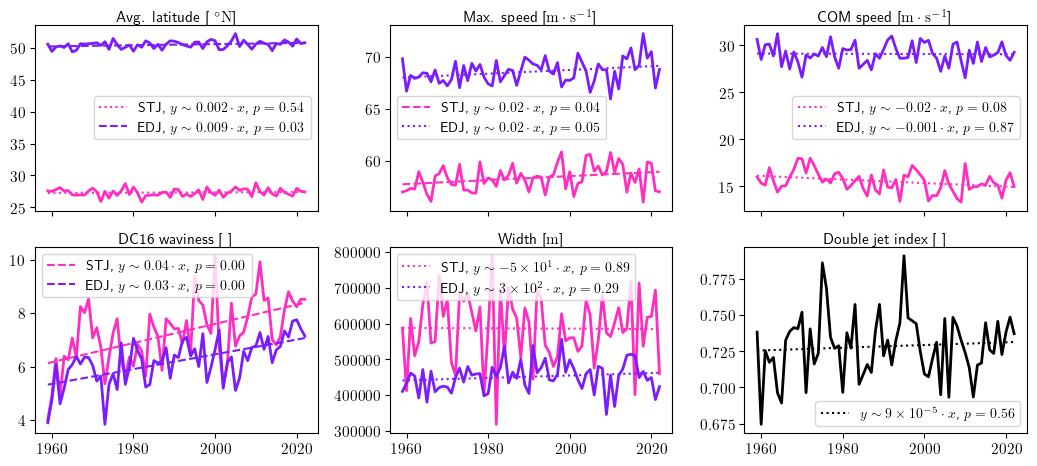

In [18]:
data_vars = [
    "mean_lat",
    "s_star",
    "com_speed",
    "wavinessDC16",
    "width",
    "double_jet_index",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(
        props_as_df,
        data_vars,
        season,
        n_boostraps=1000,
        nrows=2,
        ncols=3,
        clear=False,
        suffix="_new_subset",
    )

In [20]:
factors = {
    "mean_lat": 0.001,
    "s_star": 0.01,
    "com_speed": 0.001,
    "wavinessDC16": 0.01,
    "width": 1000,
    "double_jet_index": 0.0001,
}
# factors = {
#     "mean_lon": 0.001,
#     "mean_lat": 0.001,
#     "mean_lev": 0.01,
#     "s_star": 0.01,
#     "mean_s": 0.01,
#     "tilt": 0.0001,
#     "waviness1": 0.0001,
#     "wavinessR16": 0.0001,
#     "wavinessDC16": 0.0001,
#     "wavinessFV15": 0.00001,
#     "width": 1000,
#     "int": 1e5,
#     "int_over_europe": 1e5,
#     "persistence": 0.001,
#     "com_speed": 0.001,
#     "double_jet_index": 0.0001,
# }
bootstrap_len = 4
n_boostraps = 1000
data_vars = list(factors)
index_columns = get_index_columns(props_as_df, ("member", "time", "cluster", "jet"))
props_as_df_reduced = props_as_df.filter(pl.col("time").dt.year() >= 1979)
jets = ["STJ", "EDJ"]
seasons = list(SEASONS).copy()
seasons.append("Year")
periods = ["1959-", "1979-"]
iterables = [seasons, periods]

columns = pd.MultiIndex.from_product(iterables, names=["Season", "Period"])
iterables = [[PRETTIER_VARNAME[varname] for varname in data_vars], jets]
index = pd.MultiIndex.from_product(iterables, names=["Property", "Jet"])
df = pd.DataFrame(
    np.zeros((len(index), len(columns)), dtype="str"), index=index, columns=columns
)
for season in seasons:
    for reduced, period in zip([False, True], periods):
        if reduced:
            pads = props_as_df_reduced
        else:
            pads = props_as_df
        x, yearly, slopes, constants, pvals = trends_and_pvalues(
            pads, data_vars, season, n_boostraps=n_boostraps
        )
        slopes = slopes.filter(pl.col("sample_index") == n_boostraps).drop(
            "sample_index"
        )
        for varname, factor in factors.items():
            for jet in jets:
                c0 = constants.filter(pl.col("jet") == jet)[varname].item()
                c1 = slopes.filter(pl.col("jet") == jet)[varname].item()
                p = pvals.filter(pl.col("jet") == jet)[varname].item()
                indexer1 = ((PRETTIER_VARNAME[varname], jet), (season, period))
                p = min(p, 1 - p) * 2
                str_start = r"${" if p > 0.05 else r"$\mathbf{"
                str_ = str_start + num2tex(c1 / factor, ncomma=2) + r"}$"
                df.loc[*indexer1] = f"{c1:.2f} ({p:.2f})"
                df.loc[*indexer1] = str_
suffix = "_extended" if len(factors) > 6 else ""
df.to_latex(
    buf=f"persistent-extremes-era5/out{suffix}.tex",
    escape=False,
    column_format="l",
    multirow=False,
    header=True,
    index_names=False,
)

# Correlations

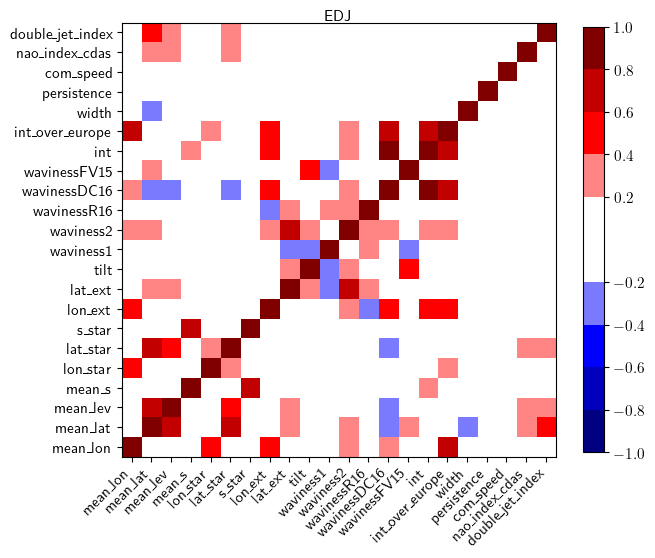

In [61]:
props_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8])).drop(
    "flag"
)
X = props_summer.filter(pl.col("jet") == "EDJ").to_numpy()[:, 2:].astype(float)
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
columns = props_summer.columns[2:]
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title("EDJ")
plt.colorbar(im, spacing="proportional", shrink=0.85)

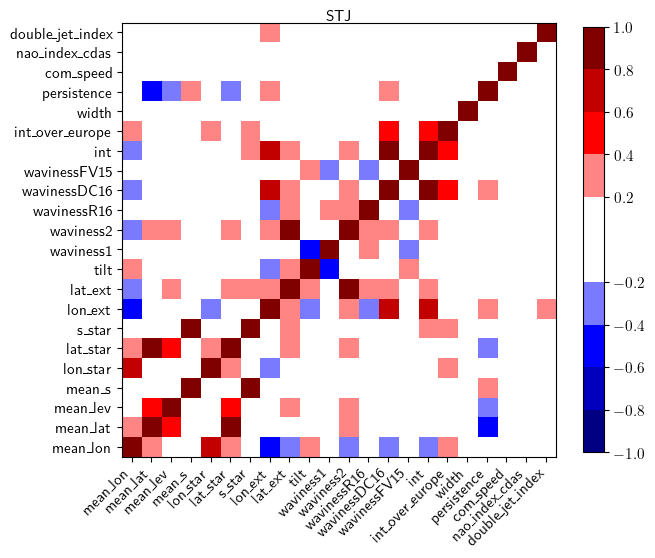

In [62]:
props_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8])).drop(
    "flag"
)
X = props_summer.filter(pl.col("jet") == "STJ").to_numpy()[:, 2:].astype(float)
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
columns = props_summer.columns[2:]
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title("STJ")
plt.colorbar(im, spacing="proportional", shrink=0.85)

In [86]:
import polars.selectors as cs

props_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8])).drop(
    "flag"
)
props_pivoted = (
    props_summer.pivot(on="jet", index="time")
    .drop("double_jet_index_STJ", "nao_index_cdas_STJ")
    .rename(
        {f"{vname}_EDJ": f"{vname}" for vname in ["double_jet_index", "nao_index_cdas"]}
    )
)
props_pivoted = props_pivoted.select(
    pl.col("time"),
    cs.contains("STJ"),
    cs.contains("EDJ"),
    pl.col("double_jet_index"),
    pl.col("nao_index_cdas"),
)

Text(0.5, 1.0, 'Merged')

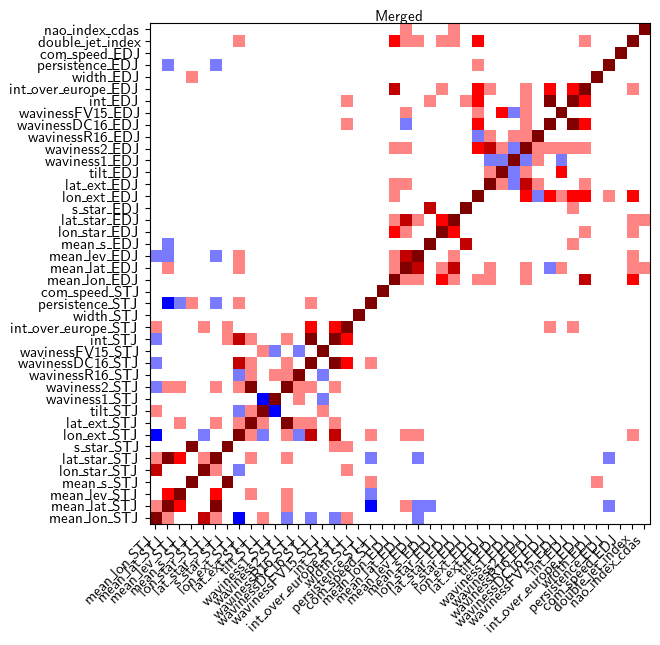

In [87]:
X = props_pivoted.to_numpy()[:, 1:]
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
columns = props_pivoted.columns[1:]
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title("Merged")

Text(0.5, 1.0, 'Merged, 1W')

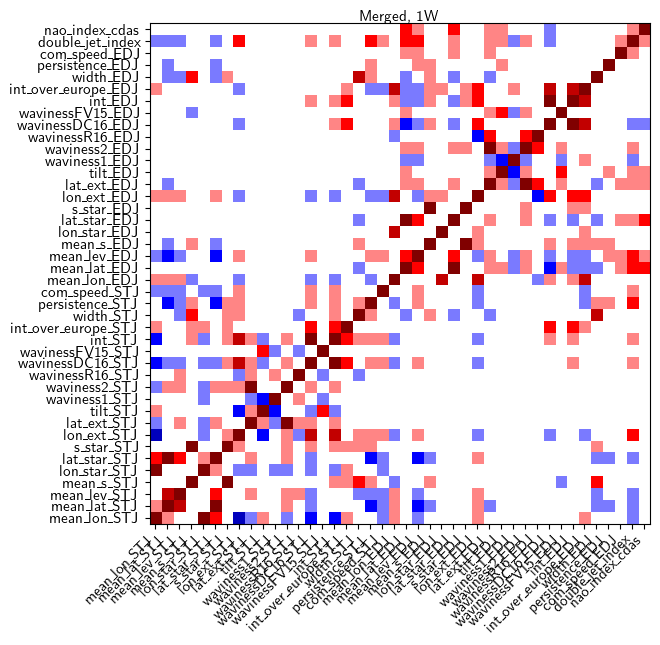

In [88]:
freq = "1W"
columns = props_pivoted.columns[1:]
props_pivoted_resampled = props_pivoted.group_by_dynamic("time", every="1w").agg(
    [pl.col(col).mean() for col in columns]
)
X = props_pivoted_resampled.to_numpy()[:, 1:]
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title(f"Merged, {freq}")

Text(0.5, 1.0, 'Merged, 1M')

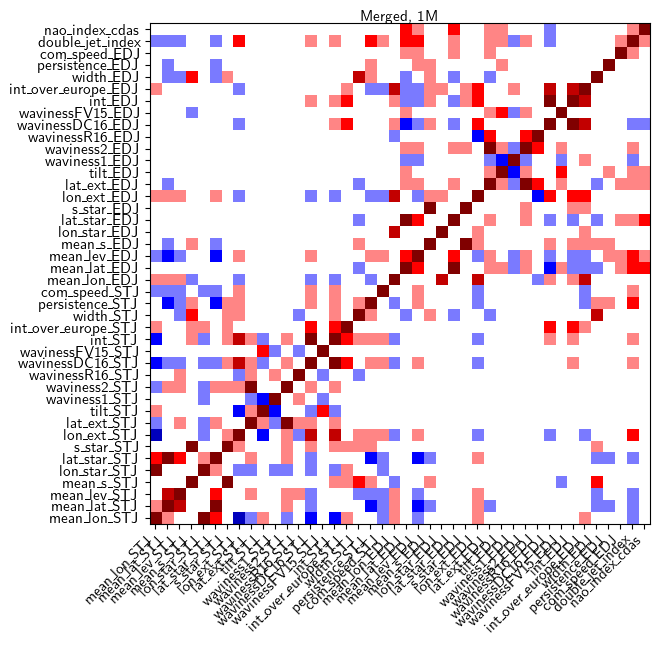

In [89]:
freq = "1M"
columns = props_pivoted.columns[1:]
props_pivoted_resampled = props_pivoted.group_by_dynamic("time", every="1w").agg(
    [pl.col(col).mean() for col in columns]
)
X = props_pivoted_resampled.to_numpy()[:, 1:]
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title(f"Merged, {freq}")

Text(0.5, 1.0, 'Merged, 1Y')

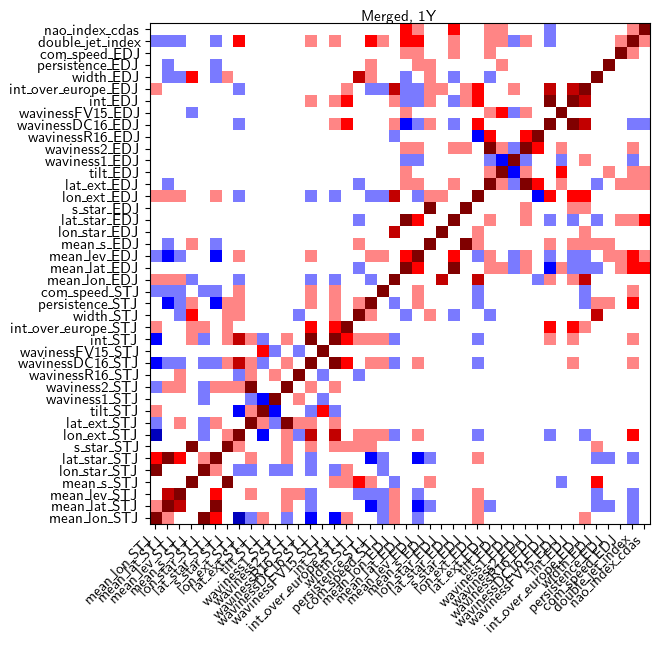

In [90]:
freq = "1Y"
columns = props_pivoted.columns[1:]
props_pivoted_resampled = props_pivoted.group_by_dynamic("time", every="1w").agg(
    [pl.col(col).mean() for col in columns]
)
X = props_pivoted_resampled.to_numpy()[:, 1:]
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title(f"Merged, {freq}")

# Seasonal variability ?

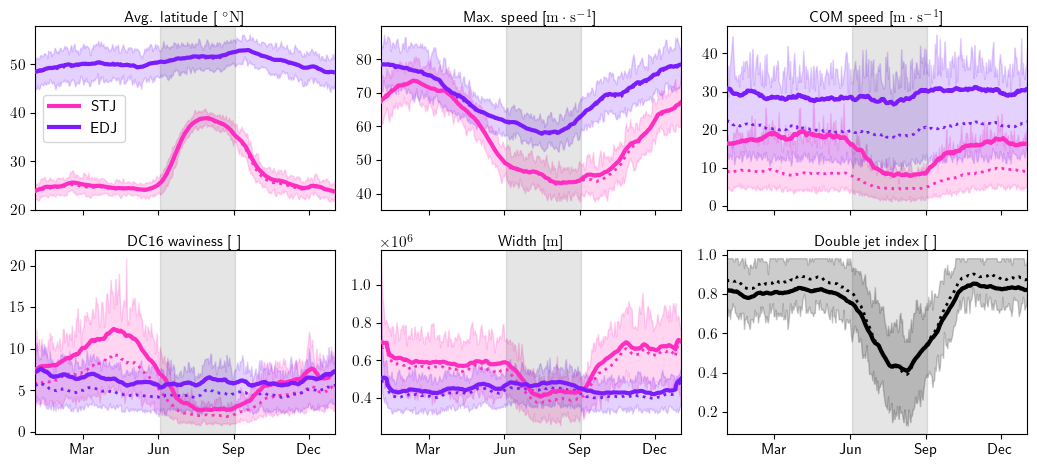

In [15]:
data_vars = [
    "mean_lat",
    "s_star",
    "com_speed",
    "wavinessDC16",
    "width",
    "double_jet_index",
]
plot_seasonal(
    props_as_df, data_vars, nrows=2, ncols=3, clear=False, suffix="_new_subset"
)

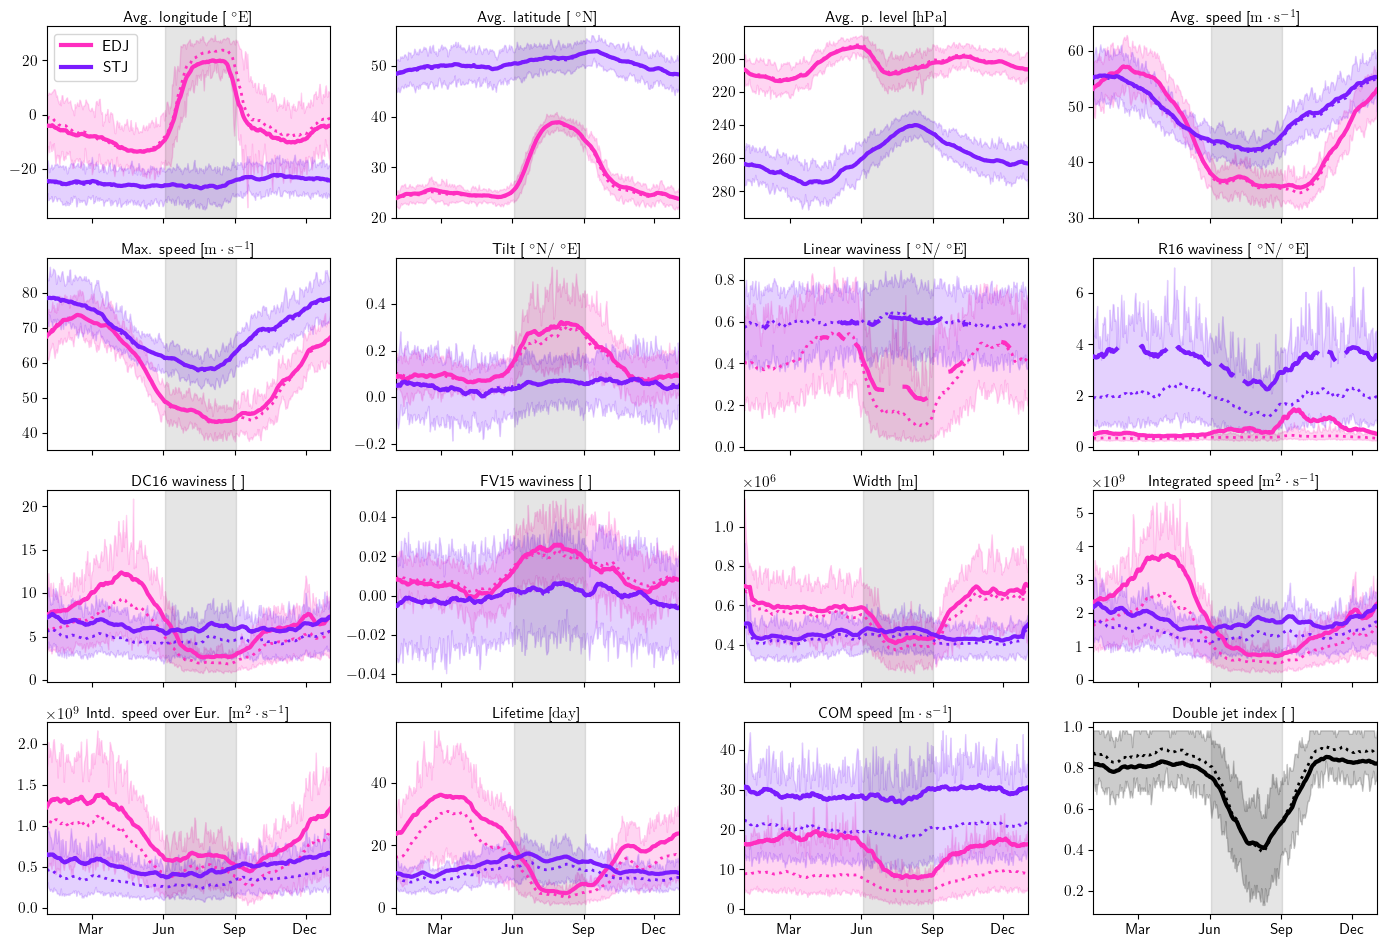

In [16]:
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
    "double_jet_index",
]
plot_seasonal(props_as_df, data_vars, nrows=4, ncols=4, clear=False, suffix="_new")

# Dayofyear trend

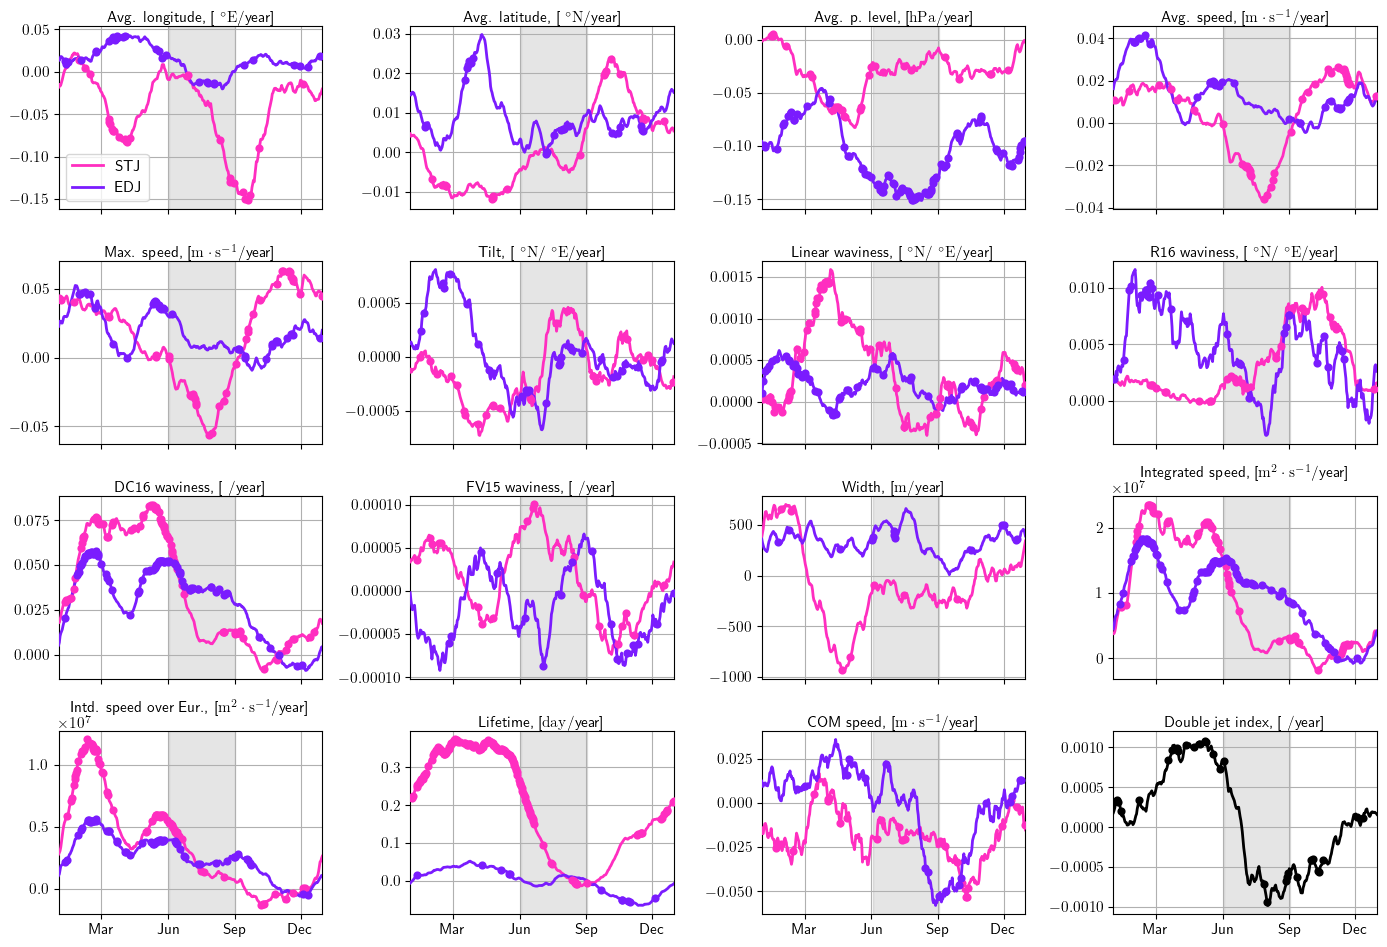

In [19]:
from matplotlib.dates import DateFormatter, MonthLocator

data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
    "double_jet_index",
]
nrows = 4
ncols = 4
winsize = 60
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 3.5, nrows * 2.4), tight_layout=True, sharex="all"
)
axes = axes.flatten()

n_years = props_as_df["time"].dt.year().n_unique()
rng = np.random.default_rng()
n_bootstraps = 100
bootstrap_len = 4
num_blocks = n_years // bootstrap_len

sample_indices = rng.choice(
    n_years - bootstrap_len - 1, size=(n_bootstraps, n_years // bootstrap_len)
)
sample_indices = sample_indices[..., None] + np.arange(bootstrap_len)[None, None, :]
sample_indices = sample_indices.reshape(n_bootstraps, num_blocks * bootstrap_len)
sample_indices = np.append(sample_indices, np.arange(n_years)[None, :], axis=0)
sample_indices = sample_indices.flatten()

props_as_df_daily = (
    props_as_df.group_by_dynamic(pl.col("time"), every="1d", group_by="jet")
    .agg(**{data_var: pl.col(data_var).mean() for data_var in data_vars})
    .sort([pl.col("time"), pl.col("jet")])
)
props_as_df_daily = props_as_df_daily.filter(pl.col("time").dt.ordinal_day() < 366)
ts_bootstrapped = (
    props_as_df_daily.group_by(
        [pl.col("time").dt.ordinal_day().alias("dayofyear"), pl.col("jet")],
        maintain_order=True,
    )
    .agg(
        **{data_var: pl.col(data_var).gather(sample_indices) for data_var in data_vars},
        year=pl.col("time").dt.year().gather(sample_indices),
        inside_index=pl.int_range(len(sample_indices)) % 64,
        sample_index=pl.int_range(len(sample_indices)) // 64,
    )
    .explode([*data_vars, "year", "inside_index", "sample_index"])
)
slopes = ts_bootstrapped.group_by(
    ["dayofyear", "sample_index", "jet"], maintain_order=True
).agg(
    **{
        data_var: pl.col(data_var)
        .least_squares.ols(
            pl.col("inside_index"),
            mode="coefficients",
            add_intercept=True,
            null_policy="drop",
        )
        .struct.field("inside_index")
        for data_var in data_vars
    }
)
pvals = slopes.group_by(["dayofyear", "jet"], maintain_order=True).agg(
    **{
        data_var: pl.col(data_var)
        .head(n_bootstraps)
        .sort()
        .search_sorted(pl.col(data_var).get(-1))
        / n_bootstraps
        for data_var in data_vars
    }
)

ys = slopes.filter(pl.col("sample_index") == n_bootstraps)
ys = periodic_rolling_pl(ys, winsize, data_vars)

for varname, ax in zip(data_vars, axes.ravel()):
    dji = varname == "double_jet_index"
    if varname == "mean_lev":
        ax.invert_yaxis()
    ax.set_title(f"{PRETTIER_VARNAME.get(varname, varname)} [{UNITS.get(varname, '')}]")
    dji = varname == "double_jet_index"
    for i, jet in enumerate(["STJ", "EDJ"]):
        color = "black" if dji else COLORS[2 - i]
        y = ys.filter(pl.col("jet") == jet)[varname]
        ps = pvals.filter(pl.col("jet") == jet)[varname]
        x = np.arange(len(y))
        ax.plot(x, y, lw=2, color=color, label=jet, zorder=10)
        filter_ = (ps > 0.975) | (ps < 0.025)
        ax.scatter(
            x[filter_],
            y.filter(filter_),
            marker=".",
            color=color,
            s=60,
            linewidths=2,
            zorder=11,
        )
        if dji:
            break
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS.get(varname, '1')}/year]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
    ylim = ax.get_ylim()
    wherex = np.isin(x, JJADOYS)
    ax.fill_between(x, *ylim, where=wherex, alpha=0.1, color="black", zorder=-10)
    ax.set_ylim(ylim)
    ax.grid(True)
axes.ravel()[0].legend().set_zorder(102)
plt.savefig(f"{FIGURES}/jet_props_misc/new_dayofyear_trends_{winsize=}.png")

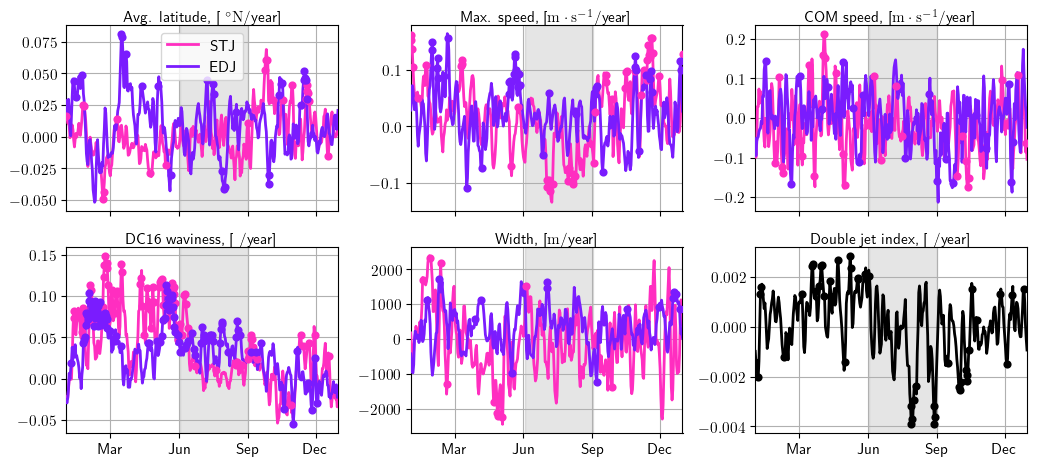

In [5]:
from matplotlib.dates import DateFormatter, MonthLocator

data_vars = [
    "mean_lat",
    "s_star",
    "com_speed",
    "wavinessDC16",
    "width",
    "double_jet_index",
]
nrows = 2
ncols = 3
winsize = 3
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 3.5, nrows * 2.4), tight_layout=True, sharex="all"
)
axes = axes.flatten()

n_years = props_as_df["time"].dt.year().n_unique()
rng = np.random.default_rng()
n_bootstraps = 100
bootstrap_len = 4
num_blocks = n_years // bootstrap_len

sample_indices = rng.choice(
    n_years - bootstrap_len - 1, size=(n_bootstraps, n_years // bootstrap_len)
)
sample_indices = sample_indices[..., None] + np.arange(bootstrap_len)[None, None, :]
sample_indices = sample_indices.reshape(n_bootstraps, num_blocks * bootstrap_len)
sample_indices = np.append(sample_indices, np.arange(n_years)[None, :], axis=0)
sample_indices = sample_indices.flatten()

props_as_df_daily = (
    props_as_df.group_by_dynamic(pl.col("time"), every="1d", group_by="jet")
    .agg(**{data_var: pl.col(data_var).mean() for data_var in data_vars})
    .sort([pl.col("time"), pl.col("jet")])
)
props_as_df_daily = props_as_df_daily.filter(pl.col("time").dt.ordinal_day() < 366)
ts_bootstrapped = (
    props_as_df_daily.group_by(
        [pl.col("time").dt.ordinal_day().alias("dayofyear"), pl.col("jet")],
        maintain_order=True,
    )
    .agg(
        **{data_var: pl.col(data_var).gather(sample_indices) for data_var in data_vars},
        year=pl.col("time").dt.year().gather(sample_indices),
        inside_index=pl.int_range(len(sample_indices)) % 64,
        sample_index=pl.int_range(len(sample_indices)) // 64,
    )
    .explode([*data_vars, "year", "inside_index", "sample_index"])
)
slopes = ts_bootstrapped.group_by(
    ["dayofyear", "sample_index", "jet"], maintain_order=True
).agg(
    **{
        data_var: pl.col(data_var)
        .least_squares.ols(
            pl.col("inside_index"),
            mode="coefficients",
            add_intercept=True,
            null_policy="drop",
        )
        .struct.field("inside_index")
        for data_var in data_vars
    }
)
pvals = slopes.group_by(["dayofyear", "jet"], maintain_order=True).agg(
    **{
        data_var: pl.col(data_var)
        .head(n_bootstraps)
        .sort()
        .search_sorted(pl.col(data_var).get(-1))
        / n_bootstraps
        for data_var in data_vars
    }
)

ys = slopes.filter(pl.col("sample_index") == n_bootstraps)
ys = periodic_rolling_pl(ys, winsize, data_vars)

for varname, ax in zip(data_vars, axes.ravel()):
    dji = varname == "double_jet_index"
    if varname == "mean_lev":
        ax.invert_yaxis()
    ax.set_title(f"{PRETTIER_VARNAME.get(varname, varname)} [{UNITS.get(varname, '')}]")
    dji = varname == "double_jet_index"
    for i, jet in enumerate(["STJ", "EDJ"]):
        color = "black" if dji else COLORS[2 - i]
        y = ys.filter(pl.col("jet") == jet)[varname]
        ps = pvals.filter(pl.col("jet") == jet)[varname]
        x = np.arange(len(y))
        ax.plot(x, y, lw=2, color=color, label=jet, zorder=10)
        filter_ = (ps > 0.975) | (ps < 0.025)
        ax.scatter(
            x[filter_],
            y.filter(filter_),
            marker=".",
            color=color,
            s=60,
            linewidths=2,
            zorder=11,
        )
        if dji:
            break
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS.get(varname, '1')}/year]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
    ylim = ax.get_ylim()
    wherex = np.isin(x, JJADOYS)
    ax.fill_between(x, *ylim, where=wherex, alpha=0.1, color="black", zorder=-10)
    ax.set_ylim(ylim)
    ax.grid(True)
axes.ravel()[0].legend().set_zorder(102)
plt.savefig(f"{FIGURES}/jet_props_misc/new_subset_dayofyear_trends_{winsize=}.png")

In [69]:
from matplotlib.dates import DateFormatter, MonthLocator

data_vars = [
    "mean_lat",
    "s_star",
    "com_speed",
    "wavinessDC16",
    "width",
    "double_jet_index",
]
nrows = 2
ncols = 3
winsize = 5

n_years = props_as_df["time"].dt.year().n_unique()
rng = np.random.default_rng()
n_bootstraps = 100
bootstrap_len = 4
num_blocks = n_years // bootstrap_len

sample_indices = rng.choice(
    n_years - bootstrap_len - 1, size=(n_bootstraps, n_years // bootstrap_len)
)
sample_indices = sample_indices[..., None] + np.arange(bootstrap_len)[None, None, :]
sample_indices = sample_indices.reshape(n_bootstraps, num_blocks * bootstrap_len)
sample_indices = np.append(sample_indices, np.arange(n_years)[None, :], axis=0)
sample_indices = sample_indices.flatten()

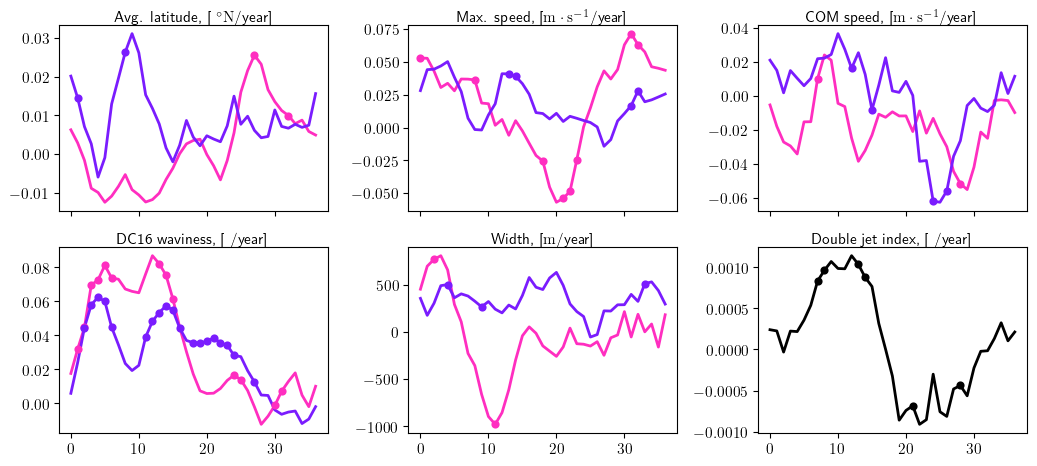

In [70]:
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 3.5, nrows * 2.4), tight_layout=True, sharex="all"
)
axes = axes.flatten()

days_per_group = 10
props_as_df_daily = props_as_df.with_columns(groupofyear=pl.col("time").dt.ordinal_day() // days_per_group, year=pl.col("time").dt.year())
props_as_df_daily = props_as_df_daily.group_by("year", "groupofyear", "jet").agg(**{data_var: pl.col(data_var).mean() for data_var in data_vars}).sort("groupofyear", "year", "jet")
ts_bootstrapped = (
    props_as_df_daily.group_by(
        [
            pl.col("groupofyear"),
            pl.col("jet"),
        ],
        maintain_order=True,
    )
    .agg(
        **{data_var: pl.col(data_var).gather(sample_indices) for data_var in data_vars},
        year=pl.col("year").gather(sample_indices),
        inside_index=pl.int_range(len(sample_indices)) % n_years,
        sample_index=pl.int_range(len(sample_indices)) // n_years,
    )
    .explode([*data_vars, "year", "inside_index", "sample_index"])
)
slopes = ts_bootstrapped.group_by(
    ["groupofyear", "sample_index", "jet"], maintain_order=True
).agg(
    **{
        data_var: pl.col(data_var)
        .least_squares.ols(
            pl.col("inside_index"),
            mode="coefficients",
            add_intercept=True,
            null_policy="drop",
        )
        .struct.field("inside_index")
        for data_var in data_vars
    }
)
pvals = slopes.group_by(["groupofyear", "jet"], maintain_order=True).agg(
    **{
        data_var: pl.col(data_var)
        .head(n_bootstraps)
        .sort()
        .search_sorted(pl.col(data_var).get(-1))
        / n_bootstraps
        for data_var in data_vars
    }
)

ys = slopes.filter(pl.col("sample_index") == n_bootstraps)
ys = periodic_rolling_pl(ys, winsize, data_vars, "groupofyear")

for varname, ax in zip(data_vars, axes.ravel()):
    dji = varname == "double_jet_index"
    if varname == "mean_lev":
        ax.invert_yaxis()
    ax.set_title(f"{PRETTIER_VARNAME.get(varname, varname)} [{UNITS.get(varname, '')}]")
    dji = varname == "double_jet_index"
    for i, jet in enumerate(["STJ", "EDJ"]):
        color = "black" if dji else COLORS[2 - i]
        y = ys.filter(pl.col("jet") == jet)[varname]
        ps = pvals.filter(pl.col("jet") == jet)[varname]
        x = np.arange(len(y))
        ax.plot(x, y, lw=2, color=color, label=jet, zorder=10)
        filter_ = (ps > 0.975) | (ps < 0.025)
        ax.scatter(
            x[filter_],
            y.filter(filter_),
            marker=".",
            color=color,
            s=60,
            linewidths=2,
            zorder=11,
        )
        if dji:
            break
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS.get(varname, '1')}/year]")
#     ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
#     ax.xaxis.set_major_formatter(DateFormatter("%b"))
#     ax.set_xlim(min(x), max(x))
#     if varname == "mean_lev":
#         ax.invert_yaxis()
#     ylim = ax.get_ylim()
#     wherex = np.isin(x, JJADOYS)
#     ax.fill_between(x, *ylim, where=wherex, alpha=0.1, color="black", zorder=-10)
#     ax.set_ylim(ylim)
#     ax.grid(True)
# axes.ravel()[0].legend().set_zorder(102)
# plt.savefig(f"{FIGURES}/jet_props_misc/new_subset_dayofyear_trends_{winsize=}.png")

In [66]:
pvals

groupofyear,jet,mean_lat,s_star,com_speed,wavinessDC16,width,double_jet_index
i16,str,f64,f64,f64,f64,f64,f64
0,"""EDJ""",0.81,0.81,0.06,0.48,0.19,0.13
0,"""STJ""",0.88,0.98,0.42,0.42,0.41,0.13
1,"""EDJ""",0.98,0.65,0.93,0.88,0.72,0.8
1,"""STJ""",0.6,0.96,0.28,1.0,0.76,0.8
2,"""EDJ""",0.9,0.74,0.62,1.0,0.77,0.85
…,…,…,…,…,…,…,…
34,"""STJ""",0.7,0.68,0.11,0.71,0.77,0.8
35,"""EDJ""",0.58,0.33,0.88,0.24,1.0,0.67
35,"""STJ""",0.76,0.62,0.7,0.48,0.23,0.67


In [62]:
df = slopes.filter(pl.col("sample_index") == n_bootstraps)
dim = "groupofyear"

In [67]:
df = slopes.filter(pl.col("sample_index") == n_bootstraps)
dim = "groupofyear"
df = df.cast({dim: pl.Int32})
halfwinsize = winsize // 2
other_columns = get_index_columns(df, ("member", "jet"))
descending = [False, *[col == "jet" for col in other_columns]]
len_ = [df[col].unique().len() for col in other_columns]
len_ = np.prod(len_)
min_doy = df[dim].min()
max_doy = df[dim].max()
df = df.sort([dim, *other_columns], descending=descending)
df = pl.concat(
    [
        df.tail(halfwinsize * len_).with_columns(pl.col(dim) - max_doy + min_doy - 1),
        df,
        df.head(halfwinsize * len_).with_columns(pl.col(dim) + max_doy - min_doy + 1),
    ]
)
df = df.rolling(
    pl.col(dim),
    period=f"{winsize}i",
    offset=f"-{halfwinsize + 1}i",
    group_by=other_columns,
).agg(*[pl.col(col).mean() for col in data_vars])
df = df.sort([dim, *other_columns], descending=descending)
df.slice(halfwinsize * len_, (max_doy - min_doy + 1) * len_)

jet,groupofyear,mean_lat,s_star,com_speed,wavinessDC16,width,double_jet_index
str,i32,f64,f64,f64,f64,f64,f64
"""STJ""",0,0.005149,0.064218,-0.004035,0.014139,317.799119,0.000079
"""EDJ""",0,0.024112,0.041666,0.019646,0.001218,76.88052,0.000079
"""STJ""",1,0.007795,0.070502,-0.01372,0.038793,918.175208,0.000123
"""EDJ""",1,0.027119,0.028328,0.007117,0.020851,83.744637,0.000123
"""STJ""",2,0.000369,0.041819,-0.029523,0.063875,1081.2328,0.000433
…,…,…,…,…,…,…,…
"""EDJ""",34,0.001354,0.000636,0.001849,-0.00799,710.795644,0.000232
"""STJ""",35,0.004345,0.022901,-0.013117,-0.005956,75.155967,0.000455
"""EDJ""",35,0.006598,0.022811,0.018563,-0.011737,583.957973,0.000455


In [10]:
days_per_group = 10
props_as_df_daily = props_as_df.with_columns(groupofyear=pl.col("time").dt.ordinal_day() // days_per_group, year=pl.col("time").dt.year())
props_as_df_daily = props_as_df_daily.group_by("year", "groupofyear", "jet").agg(**{data_var: pl.col(data_var).mean() for data_var in data_vars}).sort("year", "groupofyear", "jet")
props_as_df_daily 

year,groupofyear,jet,mean_lat,s_star,com_speed,wavinessDC16,width,double_jet_index
i32,i16,str,f32,f32,f32,f32,f32,f64
1959,0,"""EDJ""",48.573402,71.89109,34.933952,0.688182,484142.0625,0.914845
1959,0,"""STJ""",23.138805,70.222618,12.268796,0.907539,762962.875,0.914845
1959,1,"""EDJ""",47.739861,72.748123,33.488548,0.77745,384749.78125,0.75123
1959,1,"""STJ""",26.074711,72.210739,7.431228,0.808076,547138.3125,0.75123
1959,2,"""EDJ""",49.876377,75.2024,31.900776,1.391346,381224.875,0.927459
…,…,…,…,…,…,…,…,…
2022,34,"""STJ""",22.817064,56.014122,15.481891,4.387794,626807.875,0.855738
2022,35,"""EDJ""",46.185863,73.633675,34.755424,8.401562,597846.8125,0.807377
2022,35,"""STJ""",22.146996,58.380096,7.759454,4.309063,639974.875,0.807377


In [15]:
ys.filter(pl.col("jet") == "EDJ")

jet,groupofyear,mean_lat,s_star,com_speed,wavinessDC16,width,double_jet_index
str,i32,f64,f64,f64,f64,f64,f64
"""EDJ""",0,0.035335,0.07163,0.167089,0.094136,163.399097,0.001905
"""EDJ""",0,0.035335,0.07163,0.167089,0.094136,163.399097,0.001905
"""EDJ""",1,0.006674,0.017203,0.091784,0.105135,834.428867,0.000634
"""EDJ""",2,-0.007187,-0.096914,-0.078291,0.089497,1497.361521,-0.001702
"""EDJ""",3,-0.023187,-0.213003,-0.249566,0.081285,793.773454,-0.002132
…,…,…,…,…,…,…,…
"""EDJ""",31,-0.109375,-0.097805,-0.145746,-0.057506,1443.265201,-0.000756
"""EDJ""",32,-0.104879,-0.088457,-0.20112,-0.007307,1373.011481,-0.003214
"""EDJ""",33,-0.038765,-0.046652,-0.215776,0.014962,1015.135301,-0.003406


In [9]:
days_per_group = 10
ts_bootstrapped = (
    props_as_df.group_by(
        [
            (pl.col("time").dt.ordinal_day() // days_per_group).alias("groupofyear"),
            pl.col("jet"),
        ],
        maintain_order=True,
    )
    .agg(
        **{data_var: pl.col(data_var).gather(sample_indices) for data_var in data_vars},
        year=pl.col("time").dt.year().gather(sample_indices),
        inside_index=pl.int_range(len(sample_indices)) % n_years,
        sample_index=pl.int_range(len(sample_indices)) // n_years,
    )
    .explode([*data_vars, "year", "inside_index", "sample_index"])
)